Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of samples in x_train :  15360
Number of samples in y_train :  15360
Number of samples in x_test :  3840
Number of samples in submission_example :  3840
Number of features in x_train :  12
Number of features in y_train :  2
Number of features in x_test :  12
Number of features in submission_example :  2
x_train data types :  Unnamed: 0      int64
cfo_demod     float64
gain_imb      float64
iq_imb        float64
or_off        float64
quadr_err     float64
m_power       float64
ph_err        float64
mag_err       float64
evm           float64
Tosc          float64
Tmix          float64
dtype: object
y_train data types :  Unnamed: 0    int64
target        int64
dtype: object
x_test data types :  Unnamed: 0      int64
cfo_demod     float64
gain_imb      float64
iq_imb        float64
or_off        float64
quadr_err     float64
m_power       float64
ph_err  

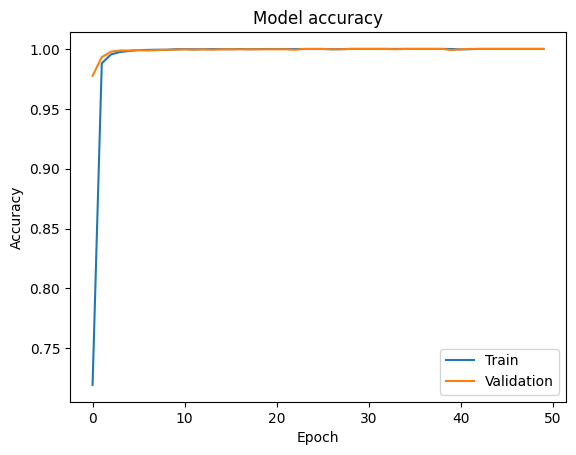

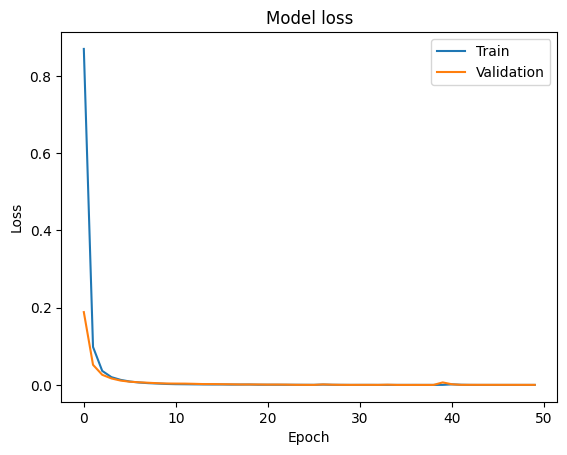

120/120 [==============================] - 0s 934us/step
The SVM accuracy is : 1.0
The SVM training time : 0.07 seconds


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

x_train_path = '/content/drive/My Drive/Datasets_project/x_train.csv'
y_train_path = '/content/drive/My Drive/Datasets_project/y_train.csv'
x_test_path = '/content/drive/My Drive/Datasets_project/x_test.csv'
submission_example_path = '/content/drive/My Drive/Datasets_project/submission_example.csv'

#We load our four datasets into pandas DataFrames
x_train_original = pd.read_csv(x_train_path)
y_train_original = pd.read_csv(y_train_path)
x_test_original = pd.read_csv(x_test_path)
submission_example_original = pd.read_csv(submission_example_path)

#We make copies of the original datasets
x_train = x_train_original.copy()
y_train = y_train_original.copy()
x_test = x_test_original.copy()
submission_example = submission_example_original.copy()

### 1/ Data examination 

#We want to get the number of samples in each dataset
print("Number of samples in x_train : ", x_train.shape[0])
print("Number of samples in y_train : ", y_train.shape[0])
print("Number of samples in x_test : ", x_test.shape[0])
print("Number of samples in submission_example : ", submission_example.shape[0])

#We want to get the number of features in each dataset
print("Number of features in x_train : ", x_train.shape[1])
print("Number of features in y_train : ", y_train.shape[1])
print("Number of features in x_test : ", x_test.shape[1])
print("Number of features in submission_example : ", submission_example.shape[1])

#We want to display the data types of the columns in each dataset
print('x_train data types : ', x_train.dtypes)
print('y_train data types : ', y_train.dtypes)
print('x_test data types : ', x_test.dtypes)
print('submission_example data types : ', submission_example.dtypes)

#We print out the number of missing values in each dataset
print('Missing values in x_train : ', x_train.isnull().sum())
print('Missing values in y_train : ', y_train.isnull().sum())
print('Missing values in x_test : ', x_test.isnull().sum())
print('Missing values in submission_example : ', submission_example.isnull().sum())

### 2/ Data preprocessing

#We drop 4 columns from x_train (Unnamed: 0, m_power, Tosc, Tmix)
x_train.drop(['Unnamed: 0','m_power', 'Tosc', 'Tmix'], axis=1, inplace=True)
x_test.drop(['Unnamed: 0','m_power', 'Tosc', 'Tmix'], axis=1, inplace=True)

### 3/ Model building and model training

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import time

#We create a list of integers representing the column indices of x_train
columns = [0, 1, 2, 3, 4, 5, 6, 7]

#We create a new pandas DataFrame called x_train_columns that has a single column called "Column Name" containing the names of the columns in x_train
x_train_columns = pd.DataFrame({'Column Name': x_train.columns})

#We add a new column called "Index" to the x_train_columns. It the row indices of each column.
x_train_columns['Index'] = x_train_columns.index
print(x_train_columns)

#We split training data into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train[x_train.columns[columns]], y_train[y_train.columns[1]], test_size=0.2)

#We scale x_train, x_val and x_test
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

y_train = y_train.values - 1   #subtract 1 to make labels in range of 0 to 7
y_val = y_val.values - 1       #subtract 1 to make labels in range of 0 to 7

#We define our model architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(columns),)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))

#We provides a summary of the layers and parameters 
model.summary()

#We compile our model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()                  #We record the start time

#We train our model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), verbose=2)

end_time = time.time()                    #We record the end time
training_time = end_time - start_time     #We calculate the elapsed time

### 4/ Performance tuning

#We evaluate our model on validation data
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)

#We print final accuracy, loss and training time
print('Accuracy : {:.2f}'.format(accuracy*100))
print('Loss : {:.2f}'.format(loss))
print(f"The MLP training time : {training_time:.2f} seconds")

import matplotlib.pyplot as plt

#We plot accuracy and validation accuracy depending on the training epoch
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#We plot loss and validation loss depending on the training epoch
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### 5/ Model evaluation

#We make predictions on the test data
predictions = model.predict(x_test)

#We get the predicted class for each test sample
predicted_classes = predictions.argmax(axis=-1)

#We load the submission example into a pandas DataFrame
submission_df = pd.read_csv(submission_example_path)

#We replace the labels in the "label" column of the submission DataFrame with the predicted class labels
submission_df["label"] = predicted_classes

#We drop the target column
df = submission_df.drop("target", axis=1)

#We replace the predicted class labels with the target labels
df["label"] = df["label"].replace({0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8})

#We rename the ‘label’ column to ‘target’  
df = df.rename(columns={'label': 'target'})

#We save the submission DataFrame to a CSV file
df.to_csv("submission.csv", index=False)

###6/ Compare MLP to SVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#We implement a Support Vector Machine
SVMmodel = SVC(kernel='linear')
start_time = time.time()                  #We record the start time
SVMmodel.fit(x_train,y_train)
end_time = time.time()                    #We record the end time
SVMmodel.get_params()
SVMmodel.score(x_val,y_val)
training_time = end_time - start_time     #We calculate the elapsed time

#We print out the accuracy and the training time
print(f"The SVM accuracy is : {SVMmodel.score(x_val,y_val)}")
print(f"The SVM training time : {training_time:.2f} seconds")